In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy
import sys
sys.path.append('./src/')

from circuit_utils import *
from network_utils import *
from learning import *
from voronoi_utils import *

In [2]:
import cmocean

edge_colormap = cmocean.cm.matter
edge_colormap_r = cmocean.cm.matter_r
node_colormap = plt.cm.coolwarm

# Load Network Example

In [3]:
# Load the trained network

filename = 'paperCircuits/2TRegression_Fig1/regressionExample_1'
allo = create_cl_from_json(f'{filename}_global.json', f'{filename}_graph.json', f'{filename}.csv')
conductances = np.array(load_from_csv(''+filename+'.csv'))
allo.jaxify()

Converted to jax


In [4]:
# Define the input and output data for task in question
inputs_source = np.c_[np.random.rand(100,2), np.zeros(100)]

coefficients = np.array([[0.15,0.3],[0.2,0.1]])
outputs_target = np.dot(coefficients, inputs_source[:,:2].T).T
train_data = split_data_into_batches(inputs_source, outputs_target, len(inputs_source))

# Plotting functions

In [5]:
from matplotlib.patches import Circle

def plot_node_state(ax, allo, node_pos, node_quantity, vmin, vmax, cmap=node_colormap, label = 'Node state'):
    node_pos -= np.mean(node_pos, axis = 0)
    mask_center = (0, 0)
    mask_radius = np.abs(node_pos).max()

    scalarmappable = allo.node_state_to_ax(ax,node_quantity, vmin = vmin, vmax = vmax,cmap=cmap,autoscale=True, color_scale='linear', plot_mode = 'voronoi')
    allo.edge_state_to_ax(ax,np.ones(allo.ne),vmin = 0, vmax = 1, lw = 0.4, cmap='Grays')
    mask = Circle(mask_center, mask_radius, transform=ax.transData, edgecolor='white', lw = 0.11,fill=False, zorder =100)
    for artist in ax.collections:  # Assuming your plot uses collections
        artist.set_clip_path(mask)
    ax.add_patch(mask)
    
    cbar = fig.colorbar(scalarmappable, ax=ax, orientation='vertical',  shrink=0.8, label=label)
    
    ax.axis('off')

    ax.set_xlim((-mask_radius,mask_radius))
    ax.set_ylim((-mask_radius,mask_radius))

    return scalarmappable

In [6]:
def plot_edge_state(ax, allo, node_pos, edge_quantity, vmin, vmax, cmap=edge_colormap, label = 'Edge state', lw=1, color_scale = 'log'):
    node_pos -= np.mean(node_pos, axis = 0)

    scalarmappable = allo.edge_state_to_ax(ax, edge_quantity, vmin = vmin, vmax = vmax,cmap=cmap,autoscale=True, color_scale=color_scale, lw=lw)
    
    cbar = fig.colorbar(scalarmappable, ax=ax, orientation='vertical',  shrink=0.8, label=label)
    
    ax.axis('off')

    return scalarmappable

In [7]:
def plot_2Source_responses(axs, allo, ratio_input, freeStateOutputs, axis_labels):

    axs.scatter(ratio_input[:,1], freeStateOutputs[:,0])
    axs.scatter(ratio_input[:,1], freeStateOutputs[:,1])
    fits = np.array([coefficients @ np.array([1, Input2]) for Input2 in ratio_input[:,1]])

    axs.plot(ratio_input[:,1], fits[:,0], c='k', zorder=-1)
    axs.plot(ratio_input[:,1], fits[:,1], c='k', zorder=-1)
    axs.set_xlabel(axis_labels[0], fontsize = 10)
    axs.set_ylabel(axis_labels[1], fontsize = 10)
    
    axs.set_xlim((-0.5,10.5))
    axs.set_ylim((-0.15,3.5))

    return 

In [8]:
def plot_matrix(axs, matrix, title, cmap = 'coolwarm', aspect=None, norm = plt.Normalize(0,1)):
    
    if aspect==None:
        im = axs.imshow(matrix, cmap = cmap, norm=norm, interpolation='None')
    else:
        im = axs.imshow(matrix, cmap = cmap, aspect = aspect, norm=norm, interpolation='None')
    
    cbar = fig.colorbar(im, ax=axs, orientation='vertical',  shrink=0.8, label=title)
    axs.set_title(title)
    return im

In [9]:
def plot_spectrum_before_after(axs, spectra, title, lintresh = 1e-1):
    
    neigenvalues = len(spectra[0])

    axs.plot(spectra[0],np.ones(neigenvalues), 'o', markersize = 10, color = 'black',alpha = 0.2)
    axs.plot(spectra[0],np.ones(neigenvalues), 'o', markersize = 10, color = 'black', markerfacecolor = 'none')
    axs.plot(spectra[1],-np.ones(neigenvalues), 'o', markersize = 10, color = 'black',alpha = 0.2)
    axs.plot(spectra[1],-np.ones(neigenvalues), 'o', markersize = 10, color = 'black', markerfacecolor = 'none')

    axs.set_xscale('symlog', linthresh=lintresh)
    axs.set_yticks([-1,1])
    axs.set_yticklabels(['After\n Training','Before\n Training'], fontsize=10)
    axs.set_title(title)
    axs.set_ylim(-2,2)

    return

In [10]:
def plot_scatter(axs, x, y, title, xlabel, ylabel, xscale = 'linear', yscale = 'linear'):

    axs.scatter(x, y)
    axs.set_xlabel(xlabel, fontsize = 10)
    axs.set_ylabel(ylabel, fontsize = 10)
    axs.set_title(title)
    axs.set_xscale(xscale)
    axs.set_yscale(yscale)

    return

In [11]:
def plot_relative_conductance(axs, allo, susceptibility_norm):

    def compute_average_conductance(inc_matrix, binary_array, conductances):
        # Step 1: Identify selected edges
        selected_edges = np.where(binary_array == 1)[0]
        
        # Initialize a list to store the average conductance for each selected edge
        averages = []
        
        for edge in selected_edges:
            # Step 2: Find the nodes connected by the edge
            nodes = np.nonzero(inc_matrix[:, edge])[0]
            
            # Step 3: Find neighboring edges and compute the sum of their conductances
            neighbor_conductances = []
            for node in nodes:
                # Find edges connected to the node, excluding the current edge
                edges = np.nonzero(inc_matrix[node, :])[0]
                for neighbor_edge in edges:
                    if neighbor_edge != edge:  # Exclude the edge itself
                        neighbor_conductances.append(conductances[neighbor_edge])
            
            # Step 4: Compute the average conductance if there are any neighbors
            if neighbor_conductances:
                averages.append(np.mean(neighbor_conductances))
            else:
                averages.append(0)  # No neighbors, so the average is 0
        
        return averages


    allo.jaxify()
    nn_mean_conductances = np.array(compute_average_conductance(allo.incidence_matrix, np.ones(allo.ne), allo.conductances))
    allo.sparsify()

    sm = allo.edge_state_to_ax(axs[0], allo.conductances, vmin=np.min(allo.conductances), vmax=np.max(allo.conductances), color_scale='log', lw=2, cmap=edge_colormap)
    axs[0].scatter(allo.pts[allo.indices_inputs[:2],0], allo.pts[allo.indices_inputs[:2],1], color='r', edgecolor='black', linewidth=1.5, s=150, zorder=2)
    axs[0].scatter(allo.pts[allo.indices_inputs[2],0], allo.pts[allo.indices_inputs[2],1], color='white', marker='s', edgecolor='black', linewidth=2, s=150, zorder=2)
    axs[0].scatter(allo.pts[allo.indices_outputs,0], allo.pts[allo.indices_outputs,1], color='b', edgecolor='black', linewidth=1.5, s=150, zorder=2)
    cbar = plt.colorbar(sm, ax=axs[0], orientation='vertical', pad=0.01)
    axs[0].set_axis_off()

    axs[2].scatter(susceptibility_norm, (allo.conductances), c = 'k', alpha=.7, s=15, zorder=2, marker='o')
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')
    axs[2].set_ylabel('Conductances')

    axs[3].scatter(susceptibility_norm, (allo.conductances/nn_mean_conductances), c = 'k', alpha=.7, s=15, zorder=2, marker='o')
    axs[3].set_xscale('log')
    axs[3].set_yscale('log')
    axs[3].set_ylabel('Relative Conductance')
    axs[3].hlines(1,np.min((allo.conductances/nn_mean_conductances)),np.max((allo.conductances/nn_mean_conductances)), color='k', linestyle='--')

    bins_histogram = np.logspace(-6, 3, num=50)
    counts, _, _ = axs[1].hist(conductances[0], bins=bins_histogram, density=False, color='k')
    counts, _, _ = axs[1].hist(allo.conductances, bins=bins_histogram, density=False, alpha=0.7, color='0.7')
    axs[1].set_xlabel('Conductances')

    axs[1].set_xscale('log')

In [12]:
def plot_current(axs, allo, current, norm=plt.Normalize(0,1), label='Current', cmap = 'coolwarm'):

    cmap = plt.cm.Greys

    for edgeIdx in np.arange(allo.ne):
        node1, node2 = list(allo.graph.edges)[edgeIdx]

        if current[edgeIdx] > 0:
            axs.arrow(allo.pts[node1,0], allo.pts[node1,1], 0.5*(allo.pts[node2,0]-allo.pts[node1,0]), 0.5*(allo.pts[node2,1]-allo.pts[node1,1]), head_width = 0.008,fc=cmap(norm(np.abs(current[edgeIdx]))), ec=cmap(norm(np.abs(current[edgeIdx]))), zorder=2)    
        elif current[edgeIdx] < 0:
            axs.arrow(allo.pts[node2,0], allo.pts[node2,1], 0.5*(allo.pts[node1,0]-allo.pts[node2,0]), 0.5*(allo.pts[node1,1]-allo.pts[node2,1]), head_width = 0.008, fc=cmap(norm(np.abs(current[edgeIdx]))), ec=cmap(norm(np.abs(current[edgeIdx]))), zorder=2)

    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.9, ax=axs, label=label)

    axs.set_axis_off()
    return

# Conductances and Voltage Response

In [13]:
# Calculate voltage state for a given input
batch = train_data[0]
circuit_input = allo.s_circuit_input_batch(batch[0], allo.indices_inputs, allo.current_bool, allo.n)[0]
free_state = allo.solve(allo.Q_inputs, circuit_input)

In [14]:
# Fix the input 1 to 1V, vary the input 2 and calculate the output for each input combination

ratio_input = np.array([[1,Vs2,0] for Vs2 in np.linspace(0,10,20)])
circuit_input = allo.s_circuit_input_batch(ratio_input, allo.indices_inputs, allo.current_bool, allo.n)

freeStateOutputs = allo.s_solve_batch(allo.conductances, allo.incidence_matrix, allo.Q_inputs, circuit_input)[:,allo.indices_outputs]

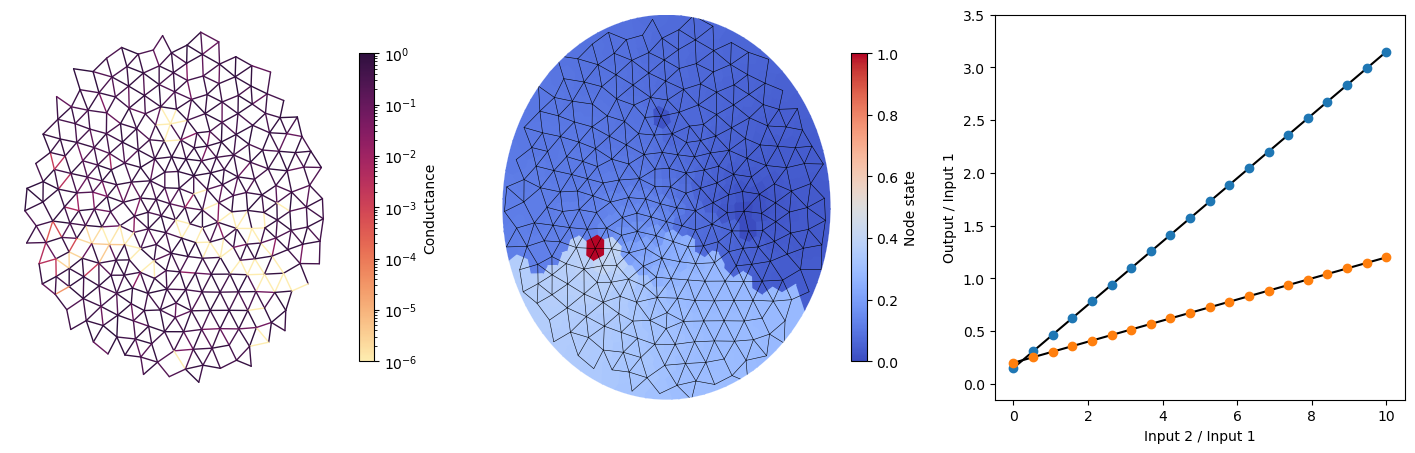

In [15]:
# Plot the Trained Conductances

fig, axs = plt.subplots(1,3, figsize=(18,5))

plot_edge_state(axs[0], allo, allo.pts, conductances[-1], vmin = 1e-6, vmax = 1, cmap=edge_colormap, label = 'Conductance', color_scale='log')
plot_node_state(axs[1], allo, allo.pts, free_state/np.max(free_state), 0, 1, cmap=plt.cm.coolwarm)
plot_2Source_responses(axs[2], allo, ratio_input, freeStateOutputs, ['Input 2 / Input 1', 'Output / Input 1'])

# Matrices

In [16]:
coefficients = np.array([[0.15,0.3],[0.2,0.1]])
outputs_target = np.dot(coefficients, inputs_source[:,:2].T).T
train_data = split_data_into_batches(inputs_source, outputs_target, len(inputs_source))

In [17]:
# Calculate the cost hesssian
batch = train_data[0]
circuit_input = allo.s_circuit_input_batch(batch[0], allo.indices_inputs, allo.current_bool, allo.n)
circuit_output = batch[1]
costHessian = allo.s_hessian_mse(allo.conductances, allo.incidence_matrix, allo.Q_inputs, allo.Q_outputs, circuit_input, circuit_output)
costHessian = (costHessian + costHessian.T)/2

In [18]:
# Calculate the susceptibility matrix; for this example the ground corresponds to the last input node

power_hessian = allo._s_hessian(allo.conductances,allo.incidence_matrix)
extended_power_hessian = jnp.block([[power_hessian, allo.Q_inputs[:,[2]]],[jnp.transpose(allo.Q_inputs[:,[2]]), jnp.zeros(shape=(1,1))]])
evals, evecs = np.linalg.eigh(extended_power_hessian)

extended_incidence_matrix = np.zeros((allo.incidence_matrix.shape[0]+(evecs.shape[0]-allo.incidence_matrix.shape[0]), allo.incidence_matrix.shape[1]))
allo.jaxify()
extended_incidence_matrix[:allo.incidence_matrix.shape[0],:] = np.array(allo.incidence_matrix)
extended_incidence_matrix[allo.incidence_matrix.shape[0]:,:] = np.zeros((evecs.shape[0]-allo.incidence_matrix.shape[0], allo.incidence_matrix.shape[1]))

devecs = (extended_incidence_matrix.T.dot(evecs[:,:])).round(11) # columns are eigenvectors
susceptibility = (devecs/evals[:]).dot(evecs[:,:].T)

Already jaxified


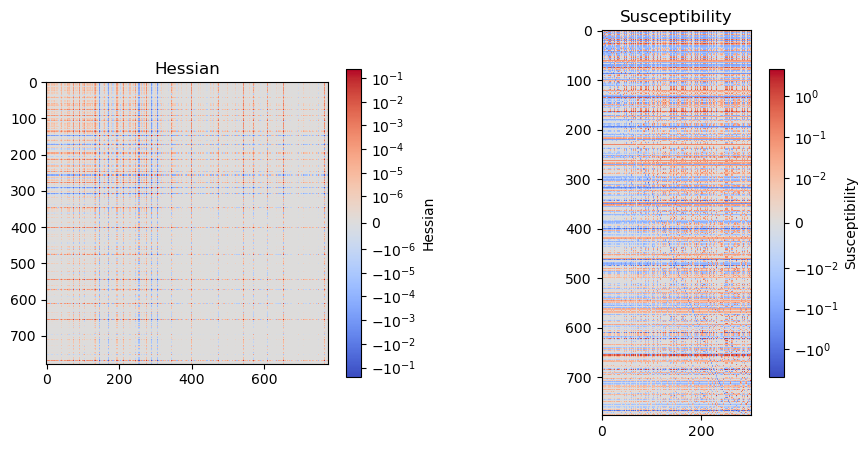

In [36]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plot_matrix(axs[0], costHessian, 'Hessian', cmap = 'coolwarm', norm=mpl.colors.SymLogNorm(linthresh=1e-6, vmin=-np.max(np.abs(costHessian)), vmax=np.max(np.abs(costHessian))))
plot_matrix(axs[1], susceptibility, aspect=1, title='Susceptibility', cmap = 'coolwarm', norm=mpl.colors.SymLogNorm(linthresh=1e-2, vmin=-np.max(np.abs(susceptibility)), vmax=np.max(np.abs(susceptibility))))

In [20]:
# Construct the projector matrix onto the output nodes

Q_projector = np.zeros((2, 300))
Q_projector[0,np.array(allo.indices_outputs)[0]] = 1
Q_projector[1,np.array(allo.indices_outputs)[1]] = 1

In [21]:
# Construct the extended input vector 

input_extended = jnp.hstack([jnp.zeros(jnp.shape(allo.incidence_matrix)[0]), inputs_source[1]])
input_extended = input_extended.reshape(input_extended.shape[0], 1)

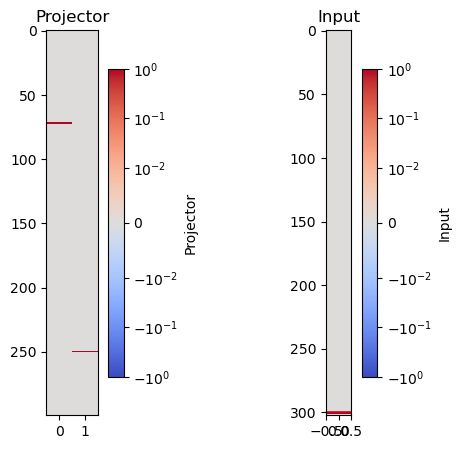

In [22]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

plot_matrix(axs[0], Q_projector.T, 'Projector', cmap = 'coolwarm', aspect=0.05, norm=mpl.colors.SymLogNorm(linthresh=1e-2, vmin=-1e0, vmax=1e0))
plot_matrix(axs[1], input_extended, 'Input', cmap = 'coolwarm', aspect=0.05, norm=mpl.colors.SymLogNorm(linthresh=1e-2, vmin=-1e0, vmax=1e0))    

# Susceptibility Vector

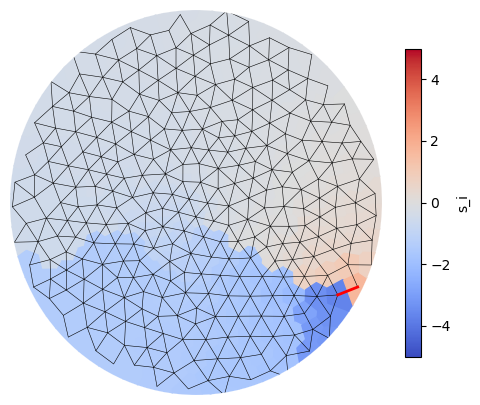

In [23]:
edgeIdx = 767

minima = -5
maxima = 5

fig, axs = plt.subplots(1,1, figsize=(6,5))
plot_node_state(axs, allo, allo.pts, susceptibility[edgeIdx], vmin = minima, vmax = maxima, cmap=plt.cm.coolwarm, label = 's_i')
axs.plot(allo.pts[list(allo.graph.edges)[edgeIdx],0], allo.pts[list(allo.graph.edges)[edgeIdx],1], 'r', lw = 2)

# Cost Stiff modes $\mu_{\rho, i}, \psi_{\rho,i}$, $|s_i|^2$ and $|s_i|^2$ vs. $|\psi_{\rho,i}|$

In [24]:
batch = train_data[0]
circuit_input = allo.s_circuit_input_batch(batch[0], allo.indices_inputs, allo.current_bool, allo.n)
circuit_output = batch[1]

In [25]:
# Calculate the cost hessian before training

costHessian = allo.s_hessian_mse(conductances[0], allo.incidence_matrix, allo.Q_inputs, allo.Q_outputs, circuit_input, circuit_output)
costHessian = 1/2*(costHessian + costHessian.T)

evals_cost_hessian_before_training, evecs_cost_hessian_before_training = jax.numpy.linalg.eigh(costHessian)
# sort eigenvalues and eigenvectors in ascending order
sorted_evals_cost_hessian_before_training = evals_cost_hessian_before_training[jax.numpy.argsort(evals_cost_hessian_before_training)]
sorted_evecs_cost_hessian_before_training = evecs_cost_hessian_before_training[:,jax.numpy.argsort(sorted_evals_cost_hessian_before_training)]

In [26]:
# Calculate the cost hessian after training

costHessian = allo.s_hessian_mse(allo.conductances, allo.incidence_matrix, allo.Q_inputs, allo.Q_outputs, circuit_input, circuit_output)
costHessian = 1/2*(costHessian + costHessian.T)

evals_cost_hessian_after_training, evecs_cost_hessian_after_training = jax.numpy.linalg.eigh(costHessian)
# sort eigenvalues and eigenvectors in ascending order
sorted_evals_cost_hessian_after_training = evals_cost_hessian_after_training[jax.numpy.argsort(evals_cost_hessian_after_training)]
sorted_evecs_cost_hessian_after_training = evecs_cost_hessian_after_training[:,jax.numpy.argsort(sorted_evals_cost_hessian_after_training)]
stiffest_mode = sorted_evecs_cost_hessian_after_training[:,-1]
stiffest_cost_mode_after = stiffest_mode*np.sign(stiffest_mode[np.argmax(np.abs(stiffest_mode))])

cumm_stiffest_cost_modes_after = jnp.asarray(jnp.sum(jnp.abs(sorted_evecs_cost_hessian_after_training[:,-4:]), axis=1), dtype=np.float64)
stiffest_cost_modes = sorted_evecs_cost_hessian_after_training[:,-4:]

/var/folders/hd/zr7tty9n6lb1b7nk6jty0mkm0000gn/T/ipykernel_7326/4256391364.py:13: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  cumm_stiffest_cost_modes_after = jnp.asarray(jnp.sum(jnp.abs(sorted_evecs_cost_hessian_after_training[:,-4:]), axis=1), dtype=np.float64)


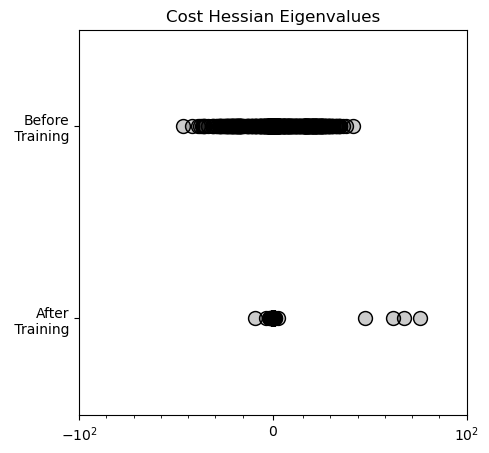

In [39]:
fig, axs = plt.subplots(1,1, figsize=(5,5))

plot_spectrum_before_after(axs, [sorted_evals_cost_hessian_before_training, sorted_evals_cost_hessian_after_training], 'Cost Hessian Eigenvalues', lintresh = 1e-4)

axs.set_xticks([-1e2,0,1e2])

Text(0.5, 0.98, 'Stiffest Cost Modes')

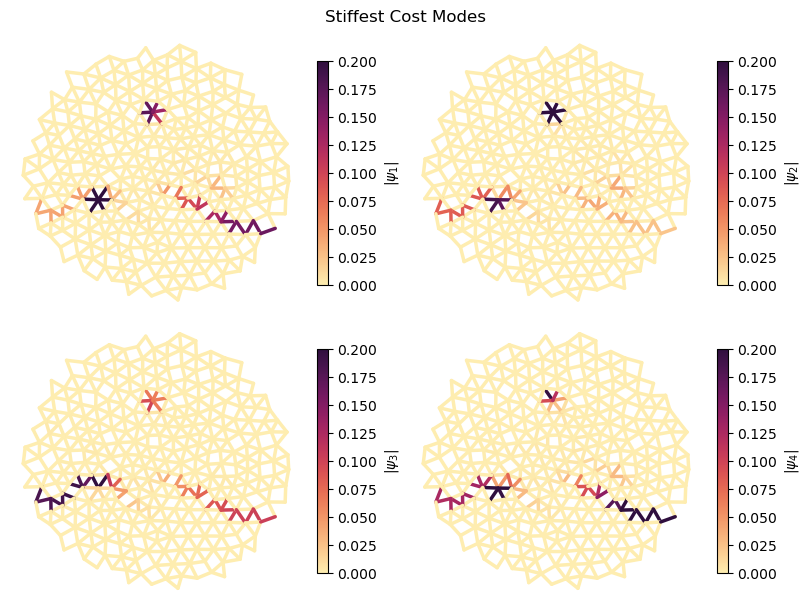

In [40]:
fig, axs = plt.subplots(2,2, figsize = (8,6), constrained_layout=True)

norm = plt.Normalize(vmin=0, vmax=0.2)
for i, ax in enumerate(axs.flatten()):
    plot_edge_state(ax, allo, allo.pts, np.abs(sorted_evecs_cost_hessian_after_training[:,-(i+1)]), vmin=0, vmax=.2, color_scale='linear', label=fr'$|\psi_{i+1}|$', cmap=edge_colormap, lw=2.5)

fig.suptitle('Stiffest Cost Modes', fontsize=12)

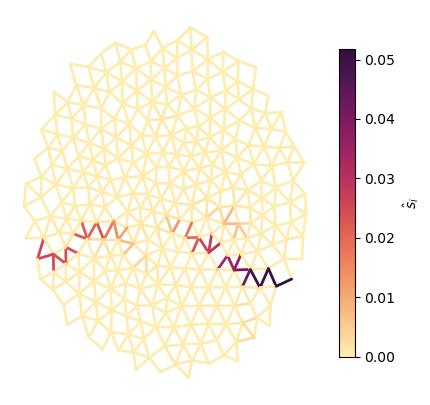

In [29]:
# Calculate the susceptibility matrix

susceptibility_norm = np.linalg.norm(susceptibility, axis=1)
susceptibility_norm = susceptibility_norm/np.linalg.norm(susceptibility_norm)

fig, axs = plt.subplots(1,1, figsize=(5,5))
plot_edge_state(axs, allo, allo.pts, susceptibility_norm**2, vmin = 0, vmax = np.max(susceptibility_norm**2), label = r'$\hat s_i$', color_scale='linear', lw=2)

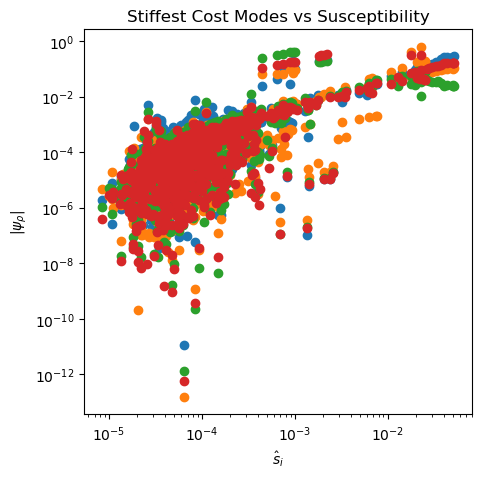

In [41]:
fig, axs = plt.subplots(1,1, figsize=(5,5))
for i in range(4):
    plot_scatter(axs, susceptibility_norm**2, np.abs(stiffest_cost_modes)[:,i], 'Stiffest Cost Modes vs Susceptibility', r'$\hat s_i$', r'$|\psi_\rho|$',  xscale='log', yscale='log')

# Low Dimensionality of Susceptibility Tensor

Already jaxified


Text(0.5, 0, 'Number of Modes')

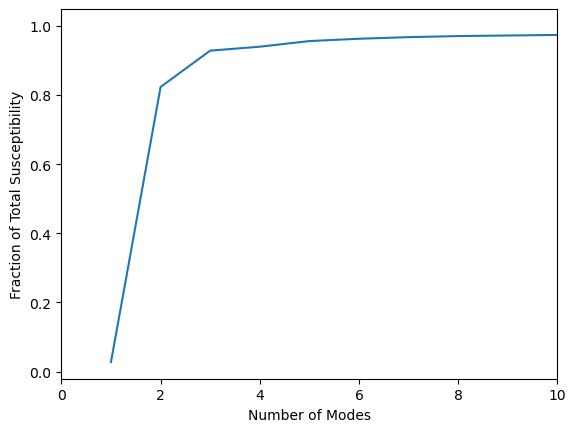

In [31]:
allo.jaxify()
power_hessian = allo._s_hessian(allo.conductances,allo.incidence_matrix)
extended_power_hessian = jnp.block([[power_hessian, allo.Q_inputs[:,[2]]],[jnp.transpose(allo.Q_inputs[:,[2]]), jnp.zeros(shape=(1,1))]])
evals, evecs = np.linalg.eigh(extended_power_hessian)

extended_incidence_matrix = np.zeros((allo.incidence_matrix.shape[0]+(evecs.shape[0]-allo.incidence_matrix.shape[0]), allo.incidence_matrix.shape[1]))
extended_incidence_matrix[:allo.incidence_matrix.shape[0],:] = np.array(allo.incidence_matrix)
extended_incidence_matrix[allo.incidence_matrix.shape[0]:,:] = np.zeros((evecs.shape[0]-allo.incidence_matrix.shape[0], allo.incidence_matrix.shape[1]))

partial_susceptibility_list = []
for nmode in range(1,302):

    devecs = (extended_incidence_matrix.T.dot(evecs[:,:nmode])).round(11) # columns are eigenvectors
    susceptibility = (devecs/evals[:nmode]).dot(evecs[:,:nmode].T)

    partial_susceptibility_list.append(np.linalg.norm(np.linalg.norm(susceptibility, axis=0)))

plt.plot(np.arange(1,302), partial_susceptibility_list/partial_susceptibility_list[-1], label=filename)
plt.xlim((0,10))
plt.ylabel('Fraction of Total Susceptibility')
plt.xlabel('Number of Modes')

# Relative Conductance and Susceptibility

Already jaxified
Converted to sparse


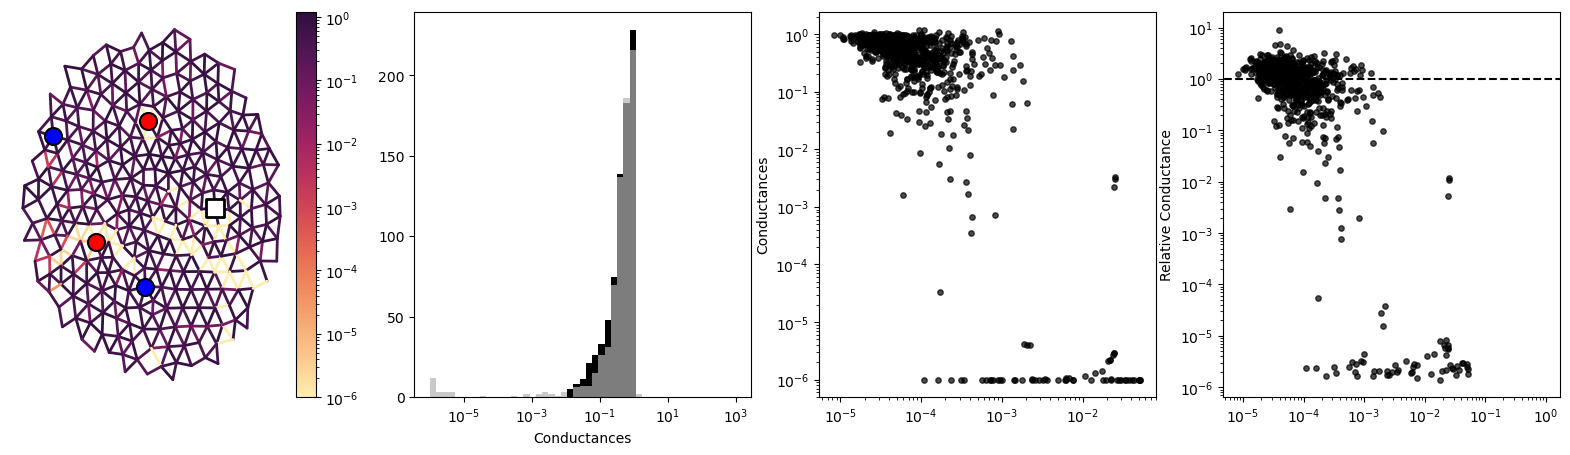

In [32]:
fig, axs = plt.subplots(1,4, figsize=(20,5))

plot_relative_conductance(axs, allo, susceptibility_norm**2)

# Current Field

In [33]:
# Calculate the current over each edge for a particular input
batch = train_data[0]
circuit_input = allo.s_circuit_input_batch(batch[0], allo.indices_inputs, allo.current_bool, allo.n)[0]
free_state = allo.solve(allo.Q_inputs, circuit_input)

allo.jaxify()
current = - np.dot(allo.incidence_matrix.T, free_state) * allo.conductances

Converted to jax


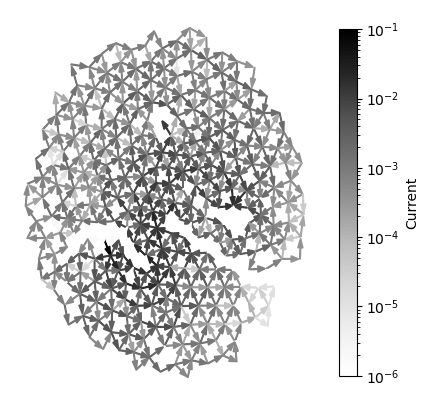

In [34]:
fig, axs = plt.subplots(1,1, figsize=(5,5))
plot_current(axs, allo, current, norm = mpl.colors.LogNorm(vmin=1e-6, vmax=1e-1), label='Current')